In [127]:
# basics
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime
import time

# plotting
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

# ml shit
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor


data_root = "../data/"

In [93]:
# cost heavy calculation(huge data)
train = pd.read_csv(data_root+"train.csv")
asset_d = pd.read_csv(data_root+"asset_details.csv")

In [94]:
train_Assets = train.groupby("Asset_ID")
btc = train_Assets.get_group(1).set_index("timestamp")
eth = train_Assets.get_group(6).set_index("timestamp")

# for candlestick chart
# btc_mini = btc.iloc[-200:]
# fig = go.Figure(data = [go.Candlestick(x=btc_mini.index,\
#     open=btc_mini["Open"], high=btc_mini["High"], low=btc_mini["Low"], close=btc_mini["Close"])])
# fig.show()

# preprocesing
btc = btc.reindex(range(eth.index[0], eth.index[-1]+60, 60), method='pad')
eth = eth.reindex(range(eth.index[0], eth.index[-1]+60, 60), method='pad')

In [95]:
# for eth and btc chart
# f = plt.figure(figsize=(12, 4))
# ax = f.add_subplot(121)
# plt.plot(btc["Close"], label="btc")
# plt.legend()

# ax2 = f.add_subplot(122)
# plt.plot(eth["Close"], label="eth", color='red')
# plt.legend()

# plt.show()

In [96]:
# get a proportion of the above to see correlation

# auxiliary function, from datetime to timestamp
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

# did this but didn't solve problem
# btc.set_index("timestamp", inplace=True)
# btc.index.name = None
# eth.set_index("timestamp", inplace=True)
# eth.index.name = None
# create intervals

btc_mini_2021 = btc.loc[totimestamp('01/06/2021'):totimestamp('01/07/2021')]
eth_mini_2021 = eth.loc[totimestamp('01/06/2021'):totimestamp('01/07/2021')]

In [97]:
# eth and btc chart 2(for correlation)
# f = plt.figure(figsize=(12, 4))
# ax = f.add_subplot(121)
# plt.plot(btc_mini_2021["Close"], label="btc")
# plt.legend()

# ax2 = f.add_subplot(122)
# plt.plot(eth_mini_2021["Close"], label="eth", color='red')
# plt.legend()

# plt.show()

In [98]:
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)[1:]

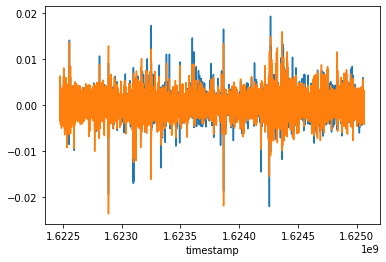

In [99]:
############## without this, we get error later ##############

lret_btc = log_return(btc_mini_2021.Close)
lret_eth = log_return(eth_mini_2021.Close)

lret_btc.rename('lret_btc', inplace=True)
lret_eth.rename('lret_eth', inplace=True)

lret_btc.plot()
lret_eth.plot()
plt.show()

<AxesSubplot:xlabel='timestamp'>

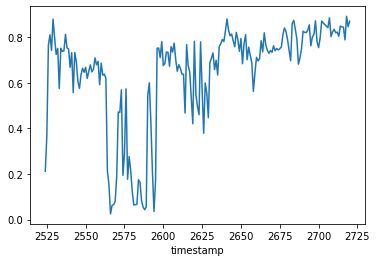

In [105]:
lret_btc_long = log_return(btc.Close)[1:]
lret_eth_long = log_return(eth.Close)[1:]
lret_btc_long.rename("lret_btc", inplace=True)
lret_eth_long.rename("lret_eth", inplace=True)
two_assets = pd.concat([lret_btc_long, lret_eth_long], axis=1)

# 近傍の点をまとめてcorrを計算している
corr_time = two_assets.groupby(two_assets.index//(10000*60)).corr()\
    .loc[:, "lret_btc"].loc[:,"lret_eth"]

corr_time.plot()
# Here we can see that there is some changing dynamics over time,\
#  and this would be critical for this time series challenge, \
# that is, how to perform forecasts in a highly non-stationary environment.

In [111]:
all_assets_2021 = pd.DataFrame()

for asset_id, asset_name in zip(asset_d.Asset_ID, asset_d.Asset_Name):
    asset = train_Assets.get_group(asset_id).set_index('timestamp')
    asset = asset.loc[totimestamp('01/01/2021'):totimestamp('01/05/2021')]
    lret = log_return(asset.Close.fillna(0))[1:]
    all_assets_2021 = all_assets_2021.join(lret, rsuffix=asset_name, how='outer')
    

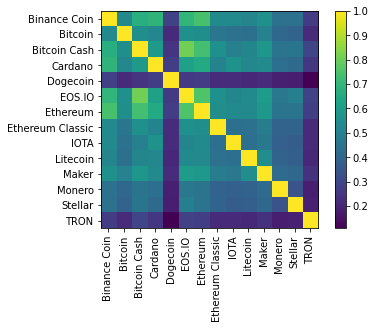

In [114]:
plt.imshow(all_assets_2021.corr());
plt.yticks(asset_d.Asset_ID.values, asset_d.Asset_Name.values)
plt.xticks(asset_d.Asset_ID.values, asset_d.Asset_Name.values, rotation="vertical")
plt.colorbar();

In [115]:
# Select some input features from the trading data: 
# 5 min log return, abs(5 min log return), upper shadow, and lower shadow.
upper_shadow = lambda asset: asset.High - np.maximum(asset.Close, asset.Open)
lower_shadow = lambda asset: -asset.Low + np.minimum(asset.Close, asset.Open)

X_btc = pd.concat([log_return(btc.VWAP, periods=5), log_return(btc.VWAP, periods=1).abs(),
                upper_shadow(btc), lower_shadow(btc)], axis=1)

y_btc = btc.Target

X_eth = pd.concat([log_return(eth.VWAP, periods=5),  log_return(eth.VWAP,periods=1).abs(), 
                upper_shadow(eth), lower_shadow(eth)], axis=1)

y_eth = eth.Target

In [116]:
train_window = [totimestamp("01/05/2021"), totimestamp("30/05/2021")]
test_window = [totimestamp("01/06/2021"), totimestamp("30/06/2021")]

X_btc_train = X_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()
y_btc_train = y_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()

X_btc_test = X_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()
y_btc_test = y_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 


X_eth_train = X_eth.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  
y_eth_train = y_eth.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  

X_eth_test = X_eth.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 
y_eth_test = y_eth.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 

In [124]:
# scale variables
scaler = StandardScaler()

X_btc_train_scaled = scaler.fit_transform(X_btc_train)
X_btc_test_scaled = scaler.fit_transform(X_btc_test)

X_eth_train_scaled = scaler.fit_transform(X_eth_train)
X_eth_test_scaled = scaler.transform(X_eth_test)

In [126]:
# simple linear regression
lr = LinearRegression()

lr.fit(X_btc_train_scaled, y_btc_train)
y_pred_lr_btc = lr.predict(X_btc_test_scaled)

lr.fit(X_eth_train_scaled, y_eth_train)
y_pred_lr_eth = lr.predict(X_eth_test_scaled) 

In [130]:
# multi target regression

X_both_train = np.concatenate((X_btc_train_scaled, X_eth_train_scaled), axis=1)
X_both_test = np.concatenate((X_btc_test_scaled, X_eth_test_scaled), axis=1)
y_both_train = np.column_stack((y_btc_train, y_eth_train))
y_both_test = np.column_stack((y_btc_test, y_eth_test))

mlr = MultiOutputRegressor(LinearRegression())
lr.fit(X_both_train, y_both_train)
y_pred_lr_both = lr.predict((X_both_test))